# 🧮 5. Data Preprocessing
## 5.1 Tujuan

Tahap Data Preprocessing bertujuan untuk mengubah data audio mentah menjadi data numerik yang siap digunakan untuk proses modeling. Proses ini meliputi pembacaan file audio, normalisasi sinyal, penghapusan noise, pemotongan bagian diam, serta ekstraksi fitur statistik time series seperti mean, standard deviation, RMS, dan zero crossing rate (ZCR).

## 5.2 Langkah-Langkah Preprocessing
### a. Import Library yang Dibutuhkan

In [31]:
import os
import numpy as np
import librosa
import librosa.display
import soundfile as sf       
import matplotlib.pyplot as plt
from tqdm import tqdm
from pathlib import Path
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
import pickle

## b.Lakukan preprocessing

membuat fungsi preprocessing audio, yang akan:

✅ Membaca semua file .wav dari masing-masing orang dan kelas

✅ Normalisasi amplitudo

✅ Trimming bagian diam

✅ Zero-padding agar durasi seragam (misalnya 2 detik @16kHz = 32000 sampel)

✅ Simpan hasil bersih ke folder preprocces_person1,2

In [29]:
# ==========================
# PATH DATASET
# ==========================
DATASET_PERSON1 = r"D:\KULIAH\SEMESTER 5\Program Saint Data\Uranus\myfirstbook\Audio_recognition\Dataset_Voice_pertama"
DATASET_PERSON2 = r"D:\KULIAH\SEMESTER 5\Program Saint Data\Uranus\myfirstbook\Audio_recognition\Dataset_Voice_kedua"

OUTPUT_PERSON1 = r"D:\KULIAH\SEMESTER 5\Program Saint Data\Uranus\myfirstbook\Audio_recognition\preprocessed_person1"
OUTPUT_PERSON2 = r"D:\KULIAH\SEMESTER 5\Program Saint Data\Uranus\myfirstbook\Audio_recognition\preprocessed_person2"

os.makedirs(OUTPUT_PERSON1, exist_ok=True)
os.makedirs(OUTPUT_PERSON2, exist_ok=True)

# ==========================
# PARAMETER PREPROCESSING
# ==========================
TARGET_SR = 16000          
TARGET_DURATION = 3.0      
TARGET_LEN = int(TARGET_SR * TARGET_DURATION)


# ==========================
# FUNGSI PREPROCESSING
# ==========================
def preprocess_audio(file_path):
    try:
        y, sr = librosa.load(file_path, sr=TARGET_SR)
        y = librosa.util.normalize(y)
        y, _ = librosa.effects.trim(y, top_db=25)

        if len(y) < TARGET_LEN:
            y = np.pad(y, (0, TARGET_LEN - len(y)), mode='constant')
        else:
            y = y[:TARGET_LEN]

        return y, sr
    except Exception as e:
        print(f"❌ Error memproses {file_path}: {e}")
        return None, None


# ==========================
# PREPROCESS DATASET PERSON 1
# ==========================
print("\n🎤 Memproses: Dataset_Voice_pertama")

# Hanya folder yang berakhiran "_wav" 
valid_folders = [f for f in os.listdir(DATASET_PERSON1) if f.endswith("_wav")]

for label_folder in valid_folders:
    label_path = os.path.join(DATASET_PERSON1, label_folder)
    if not os.path.isdir(label_path):
        continue

    # Buat nama label tanpa "_wav" biar rapi di output
    label_clean = label_folder.replace("_wav", "")
    out_dir = os.path.join(OUTPUT_PERSON1, label_clean)
    os.makedirs(out_dir, exist_ok=True)

    for file in tqdm(os.listdir(label_path), desc=f"Person1/{label_clean}"):
        if file.endswith(".wav"):
            in_path = os.path.join(label_path, file)
            out_path = os.path.join(out_dir, file)

            y, sr = preprocess_audio(in_path)
            if y is not None:
                sf.write(out_path, y, sr)


# ==========================
# PREPROCESS DATASET PERSON 2
# ==========================
print("\n🎙️ Memproses: Dataset_Voice_kedua")

# Person kedua sudah rapi ("buka", "tutup")
for label_folder in os.listdir(DATASET_PERSON2):
    label_path = os.path.join(DATASET_PERSON2, label_folder)
    if not os.path.isdir(label_path):
        continue

    out_dir = os.path.join(OUTPUT_PERSON2, label_folder)
    os.makedirs(out_dir, exist_ok=True)

    for file in tqdm(os.listdir(label_path), desc=f"Person2/{label_folder}"):
        if file.endswith(".wav"):
            in_path = os.path.join(label_path, file)
            out_path = os.path.join(out_dir, file)

            y, sr = preprocess_audio(in_path)
            if y is not None:
                sf.write(out_path, y, sr)

print("\n✅ Preprocessing selesai.")
print(f"📁 Output Person1: {OUTPUT_PERSON1}")
print(f"📁 Output Person2: {OUTPUT_PERSON2}")



🎤 Memproses: Dataset_Voice_pertama


Person1/Tutup: 100%|██████████| 50/50 [00:01<00:00, 43.65it/s]



🎙️ Memproses: Dataset_Voice_kedua


Person2/Tutup: 100%|██████████| 48/48 [00:01<00:00, 42.14it/s]


✅ Preprocessing selesai.
📁 Output Person1: D:\KULIAH\SEMESTER 5\Program Saint Data\Uranus\myfirstbook\Audio_recognition\preprocessed_person1
📁 Output Person2: D:\KULIAH\SEMESTER 5\Program Saint Data\Uranus\myfirstbook\Audio_recognition\preprocessed_person2


### c. Fungsi Ekstraksi Fitur Statistik

Fungsi ini akan membaca setiap file .wav, melakukan preprocessing dasar, lalu menghitung fitur statistik dari sinyal time domain.

In [32]:
def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=SAMPLE_RATE, mono=True)
    features = []

    # ----- 1. Statistik -----
    features += [
        np.mean(y),
        np.std(y),
        np.var(y),
        np.mean((y - np.mean(y))**3)/(np.std(y)**3 + 1e-6),
        np.mean((y - np.mean(y))**4)/(np.std(y)**4 + 1e-6),
        np.sqrt(np.mean(y**2)),  # RMS
        np.mean(librosa.feature.zero_crossing_rate(y)),
        np.mean(y**2),
        np.std(y**2),
        np.max(y) - np.min(y)
    ]

    # ----- 2. Spektral -----
    spec_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
    spec_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    spec_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    spec_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    spec_flatness = librosa.feature.spectral_flatness(y=y)
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=5)

    features += [
        np.mean(spec_centroid), np.std(spec_centroid),
        np.mean(spec_bandwidth), np.std(spec_bandwidth),
        np.mean(spec_contrast), np.std(spec_contrast),
        np.mean(spec_rolloff), np.std(spec_rolloff),
        np.mean(spec_flatness), np.std(spec_flatness),
        np.mean(chroma), np.std(chroma)
    ]

    # MFCC (5 koef → mean & std)
    for i in range(5):
        features.append(np.mean(mfcc[i]))
    for i in range(5):
        features.append(np.std(mfcc[i]))

    # ----- 3. Temporal -----
    features.append(librosa.get_duration(y=y, sr=sr))

    onset_env = librosa.onset.onset_strength(y=y, sr=sr)
    tempo = librosa.beat.tempo(onset_envelope=onset_env, sr=sr)
    features.append(float(tempo[0]))
    features.append(np.mean(onset_env))

    autocorr = np.correlate(y, y, mode='full')
    mid = len(autocorr)//2
    features.append(np.argmax(autocorr[mid+1:]) + 1)

    envelope = np.abs(onset_env)
    features.append(np.mean(envelope))
    features.append(np.std(envelope))

    return features


### d. Looping untuk Mengambil Fitur dari Semua File

Kita akan mengambil semua file dari folder buka dan tutup, lalu menambahkan label untuk tiap file.

In [33]:
# ==========================
# Ekstraksi fitur dari semua file audio
# ==========================
data_rows = []
labels = []

# Loop semua folder orang (misalnya Person1 dan Person2)
for base_path in [PREP_PERSON1, PREP_PERSON2]:
    for label_folder in os.listdir(base_path):
        folder_path = os.path.join(base_path, label_folder)
        if not os.path.isdir(folder_path):
            continue

        # Loop semua file .wav dalam folder label
        for file_name in os.listdir(folder_path):
            if file_name.endswith(".wav"):
                file_path = os.path.join(folder_path, file_name)
                feats = extract_features(file_path)  # <== Panggil fungsi yang kamu buat
                data_rows.append(feats)
                labels.append(label_folder)

# ==========================
# Simpan hasil ke CSV
# ==========================
columns = [
    # Statistik (10)
    "mean","std","var","skew","kurtosis","rms","zcr","energy_mean","energy_std","amplitude_range",
    # Spektral (20)
    "spec_centroid_mean","spec_centroid_std","spec_bandwidth_mean","spec_bandwidth_std",
    "spec_contrast_mean","spec_contrast_std",
    "spec_rolloff_mean","spec_rolloff_std",
    "spec_flatness_mean","spec_flatness_std",
    "chroma_mean","chroma_std",
    "mfcc1_mean","mfcc2_mean","mfcc3_mean","mfcc4_mean","mfcc5_mean",
    "mfcc1_std","mfcc2_std","mfcc3_std","mfcc4_std","mfcc5_std",
    # Temporal (6)
    "duration","tempo","onset_rate","autocorr_lag","envelope_mean","envelope_std"
]

df = pd.DataFrame(data_rows, columns=columns)
df['label'] = labels
df.to_csv(OUTPUT_CSV, index=False)

print(f"\n✅ Ekstraksi fitur selesai! Tersimpan di: {OUTPUT_CSV}")


C:\Users\user\AppData\Local\Temp\ipykernel_8924\648387902.py:47: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  tempo = librosa.beat.tempo(onset_envelope=onset_env, sr=sr)



✅ Ekstraksi fitur selesai! Tersimpan di: D:\KULIAH\SEMESTER 5\Program Saint Data\Uranus\myfirstbook\Audio_recognition\fitur_audio.csv


### e. Split Data


In [34]:
# ==========================
# PATH CSV FITUR
# ==========================
CSV_PATH = r"D:\KULIAH\SEMESTER 5\Program Saint Data\Uranus\myfirstbook\Audio_recognition\fitur_audio.csv"

# ==========================
# 1️⃣ Membaca dataset
# ==========================
df = pd.read_csv(CSV_PATH)
print("Dataset shape:", df.shape)
print(df.head())

# Pastikan kolom label ada
if 'label' not in df.columns:
    raise ValueError("Kolom 'label' tidak ditemukan di CSV!")

# ==========================
# 2️⃣ Memisahkan fitur dan label
# ==========================
feature_columns = [c for c in df.columns if c not in ['file', 'label']]
X = df[feature_columns].values
y = df['label'].values

# ==========================
# 3️⃣ Encode label menjadi numerik
# ==========================
le = LabelEncoder()
y_encoded = le.fit_transform(y)
print("Label mapping:", dict(zip(le.classes_, le.transform(le.classes_))))

# ==========================
# 4️⃣ Split train-validation (80:20)
# ==========================
# Pastikan stratify bisa diterapkan
if len(np.unique(y_encoded)) == 1:
    stratify_param = None
else:
    stratify_param = y_encoded

X_train, X_val, y_train, y_val = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=stratify_param
)
print("Train shape:", X_train.shape, y_train.shape)
print("Validation shape:", X_val.shape, y_val.shape)

# ==========================
# 5️⃣ Standardisasi fitur
# ==========================
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# ==========================
# 6️⃣ Simpan dataset dalam format .pkl
# ==========================
train_data = {'X': X_train_scaled, 'y': y_train}
val_data   = {'X': X_val_scaled, 'y': y_val}

with open("train_dataset.pkl", "wb") as f:
    pickle.dump(train_data, f)

with open("val_dataset.pkl", "wb") as f:
    pickle.dump(val_data, f)

print("✅ Dataset train & validation berhasil disimpan dalam .pkl")

Dataset shape: (197, 39)
       mean       std       var      skew   kurtosis       rms       zcr  \
0 -0.004283  0.105057  0.011037 -0.693534   9.942470  0.105144  0.025271   
1 -0.001409  0.145283  0.021107 -0.022192   8.075341  0.145289  0.032725   
2 -0.003556  0.069244  0.004795  0.137091  27.158209  0.069335  0.022056   
3 -0.002982  0.090287  0.008152 -0.065390  14.862787  0.090336  0.025546   
4 -0.001062  0.094078  0.008851  0.301023  14.986006  0.094084  0.020269   

   energy_mean  energy_std  amplitude_range  ...  mfcc3_std  mfcc4_std  \
0     0.011055    0.033374         1.831390  ...  20.404310  18.146652   
1     0.021109    0.056220         1.753235  ...  26.335620  18.604534   
2     0.004807    0.025062         1.761902  ...  14.984013  19.094227   
3     0.008161    0.030609         1.745789  ...  17.208334  21.125862   
4     0.008852    0.033310         1.999390  ...  12.567668  14.353314   

   mfcc5_std  duration       tempo  onset_rate  autocorr_lag  envelope_me

### f. Analisa dan pemilihan Fitur terbaik

Training Random Forest untuk analisis feature importance...

HASIL ANALISIS FEATURE IMPORTANCE
--------------------------------------------------
Total fitur awal: 38
Threshold: 25% dari importance maksimum
Absolute threshold: 0.063096
Fitur yang dipilih: 3
Fitur yang dihapus: 35


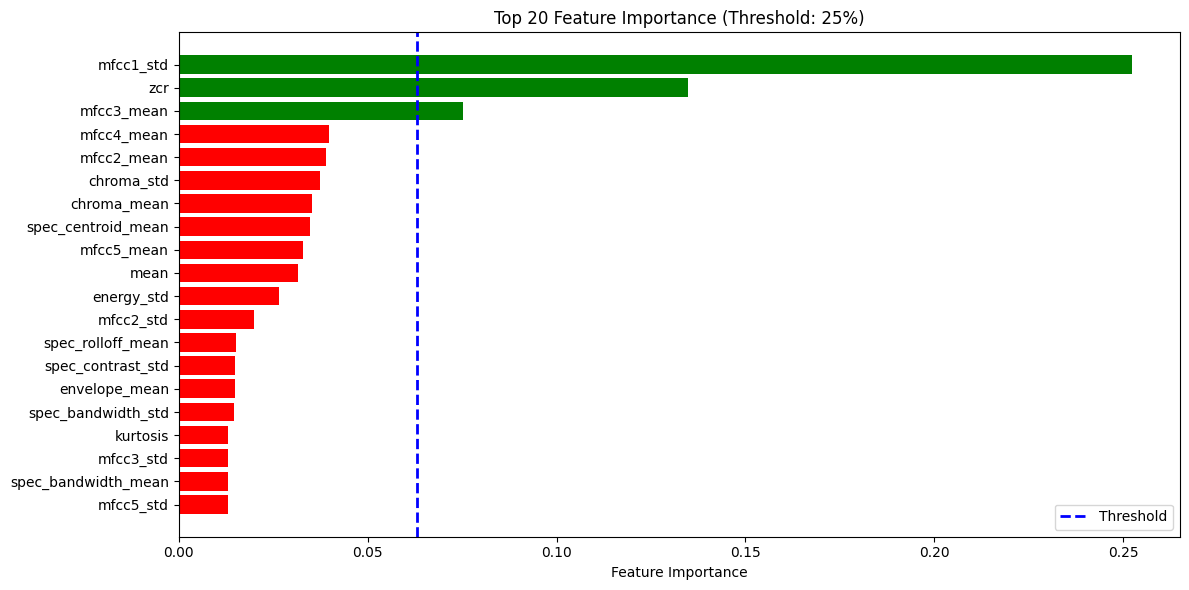


MENYIMPAN DATASET TERPILIH
--------------------------------------------------
Shape train terpilih: (157, 4)
Shape val terpilih: (40, 4)

✅ Dataset dengan fitur terpilih sudah tersimpan.


In [35]:
# ==========================
# LOAD SPLIT DATASET (.pkl)
# ==========================
with open("train_dataset.pkl", "rb") as f:
    train_data = pickle.load(f)
with open("val_dataset.pkl", "rb") as f:
    val_data = pickle.load(f)

# Ambil nama fitur dari CSV
CSV_PATH = r"D:\KULIAH\SEMESTER 5\Program Saint Data\Uranus\myfirstbook\Audio_recognition\fitur_audio.csv"
df = pd.read_csv(CSV_PATH)
feature_columns = [c for c in df.columns if c != 'label']

X_train = pd.DataFrame(train_data['X'], columns=feature_columns)
y_train = pd.Series(train_data['y'])
X_val = pd.DataFrame(val_data['X'], columns=feature_columns)
y_val = pd.Series(val_data['y'])

# ==========================
# FEATURE IMPORTANCE ANALYSIS
# ==========================
def feature_importance_analysis(X_train, y_train, X_val, y_val, importance_threshold=50):
    print("Training Random Forest untuk analisis feature importance...")
    rf_temp = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    rf_temp.fit(X_train, y_train)

    # Feature importance
    importances = pd.Series(rf_temp.feature_importances_, index=X_train.columns).sort_values(ascending=False)

    # Threshold absolute
    max_importance = importances.max()
    absolute_threshold = max_importance * (importance_threshold / 100)

    selected_features = importances[importances >= absolute_threshold].index.tolist()
    removed_features = importances[importances < absolute_threshold].index.tolist()

    print(f"\nHASIL ANALISIS FEATURE IMPORTANCE")
    print(f"{'-'*50}")
    print(f"Total fitur awal: {len(importances)}")
    print(f"Threshold: {importance_threshold}% dari importance maksimum")
    print(f"Absolute threshold: {absolute_threshold:.6f}")
    print(f"Fitur yang dipilih: {len(selected_features)}")
    print(f"Fitur yang dihapus: {len(removed_features)}")

    # Visualisasi top 20 fitur
    plt.figure(figsize=(12, 6))
    colors = ['green' if imp >= absolute_threshold else 'red' for imp in importances.values]
    top_features = importances.head(20)
    top_colors = colors[:20]
    plt.barh(range(len(top_features)), top_features.values, color=top_colors)
    plt.yticks(range(len(top_features)), top_features.index)
    plt.xlabel('Feature Importance')
    plt.title(f'Top 20 Feature Importance (Threshold: {importance_threshold}%)')
    plt.axvline(x=absolute_threshold, color='blue', linestyle='--', linewidth=2, label=f'Threshold')
    plt.legend()
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

    # Buat dataset dengan fitur terpilih
    X_train_selected = X_train[selected_features].copy()
    X_train_selected['label'] = y_train

    X_val_selected = X_val[selected_features].copy()
    X_val_selected['label'] = y_val

    print(f"\nMENYIMPAN DATASET TERPILIH")
    print(f"{'-'*50}")
    print(f"Shape train terpilih: {X_train_selected.shape}")
    print(f"Shape val terpilih: {X_val_selected.shape}")

    return X_train_selected, X_val_selected, selected_features, removed_features, importances

# ==========================
# Jalankan analisis
# ==========================
train_selected, val_selected, selected_features, removed_features, feature_importances = feature_importance_analysis(
    X_train, y_train, X_val, y_val, importance_threshold=25
)

# Simpan ke CSV
train_selected.to_csv("train_features_selected.csv", index=False)
val_selected.to_csv("val_features_selected.csv", index=False)
print("\n✅ Dataset dengan fitur terpilih sudah tersimpan.")


## Deteksi Outlier dan penanganannya

ANALISIS OUTLIER
TRAINING SET (157 samples):
  Iqr: 10 (6.4%)
  Zscore: 3 (1.9%)
  Isolation: 16 (10.2%)
VALIDATION SET (40 samples):
  Iqr: 2 (5.0%)
  Zscore: 0 (0.0%)
  Isolation: 4 (10.0%)


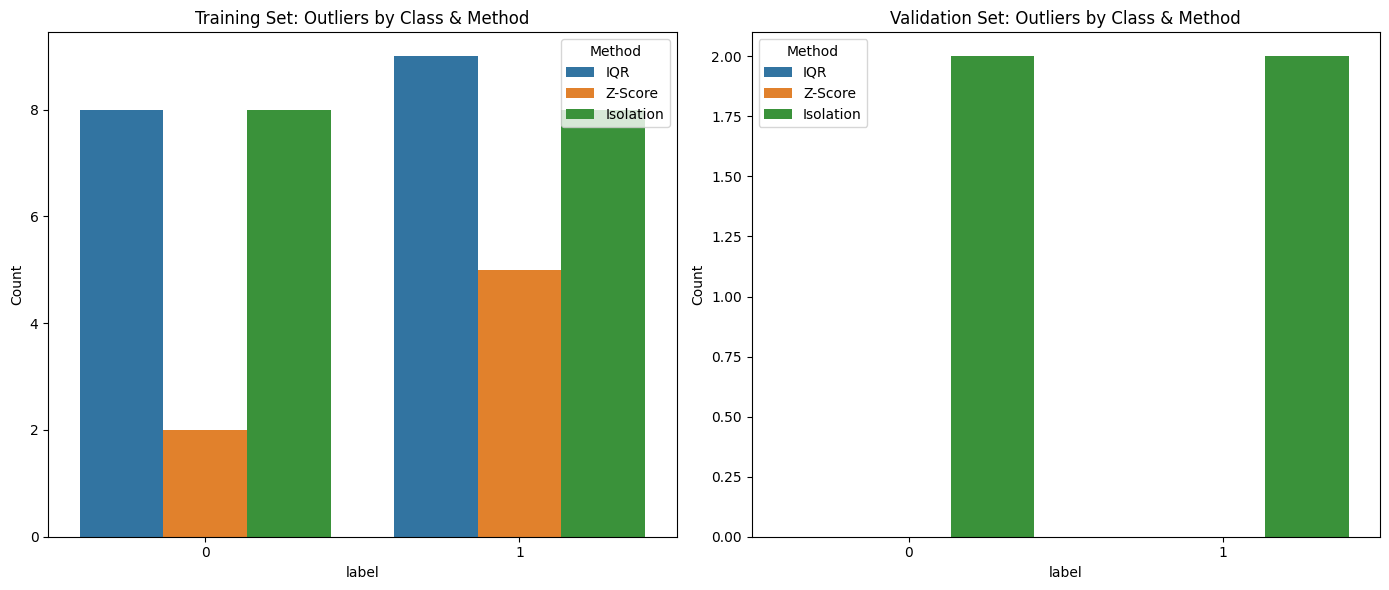


Outlier removal dengan consensus >= 2 metode:
  Original samples: 157
  Outliers removed: 10 (6.4%)
  Clean samples: 147 (93.6%)

Distribusi kelas:
  Original: {0: 79, 1: 78}
  Clean: {1: 76, 0: 71}
  Removed: {0: 8, 1: 2}

Outlier removal dengan consensus >= 2 metode:
  Original samples: 40
  Outliers removed: 2 (5.0%)
  Clean samples: 38 (95.0%)

Distribusi kelas:
  Original: {0: 20, 1: 20}
  Clean: {1: 20, 0: 18}
  Removed: {0: 2}

✅ Dataset clean dan outlier removed sudah disimpan:
  train_features_clean.csv: (147, 4)
  val_features_clean.csv: (38, 4)
  train_outliers_removed.csv: (10, 4)
  val_outliers_removed.csv: (2, 4)


In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

# ===============================
# Fungsi deteksi outlier dengan beberapa metode
# ===============================
def detect_outliers_multiple_methods(df, contamination=0.1):
    X = df.drop(columns=['label'])
    
    # Method 1: IQR
    Q1 = X.quantile(0.25)
    Q3 = X.quantile(0.75)
    IQR = Q3 - Q1
    outlier_mask_iqr = ((X < (Q1 - 1.5 * IQR)) | (X > (Q3 + 1.5 * IQR))).any(axis=1)
    
    # Method 2: Z-Score
    scaler = StandardScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
    outlier_mask_zscore = (np.abs(X_scaled) > 3).any(axis=1)
    
    # Method 3: Isolation Forest
    iso_forest = IsolationForest(contamination=contamination, random_state=42)
    outlier_mask_iso = iso_forest.fit_predict(X_scaled) == -1
    
    return {
        'iqr_outliers': outlier_mask_iqr,
        'zscore_outliers': outlier_mask_zscore,
        'isolation_outliers': outlier_mask_iso,
        'X_scaled': X_scaled
    }

# ===============================
# Analisis dan visualisasi outlier
# ===============================
def analyze_outliers(train_df, val_df, contamination=0.1):
    print("ANALISIS OUTLIER")
    print("="*50)
    
    train_outliers = detect_outliers_multiple_methods(train_df, contamination)
    val_outliers = detect_outliers_multiple_methods(val_df, contamination)
    
    # Hitung jumlah outlier
    def print_counts(name, out_dict, df):
        print(f"{name} ({len(df)} samples):")
        for method in ['iqr_outliers','zscore_outliers','isolation_outliers']:
            count = out_dict[method].sum()
            print(f"  {method.replace('_outliers','').capitalize()}: {count} ({count/len(df)*100:.1f}%)")
    
    print_counts("TRAINING SET", train_outliers, train_df)
    print_counts("VALIDATION SET", val_outliers, val_df)
    
    # Visualisasi bar chart per kelas
    fig, axes = plt.subplots(1,2, figsize=(14,6))
    
    # Training
    train_summary = train_df.groupby('label').apply(
        lambda x: pd.Series({
            'IQR': detect_outliers_multiple_methods(x)['iqr_outliers'].sum(),
            'Z-Score': detect_outliers_multiple_methods(x)['zscore_outliers'].sum(),
            'Isolation': detect_outliers_multiple_methods(x)['isolation_outliers'].sum()
        })
    ).reset_index()
    train_melted = pd.melt(train_summary, id_vars=['label'], var_name='Method', value_name='Count')
    sns.barplot(data=train_melted, x='label', y='Count', hue='Method', ax=axes[0])
    axes[0].set_title('Training Set: Outliers by Class & Method')
    
    # Validation
    val_summary = val_df.groupby('label').apply(
        lambda x: pd.Series({
            'IQR': detect_outliers_multiple_methods(x)['iqr_outliers'].sum(),
            'Z-Score': detect_outliers_multiple_methods(x)['zscore_outliers'].sum(),
            'Isolation': detect_outliers_multiple_methods(x)['isolation_outliers'].sum()
        })
    ).reset_index()
    val_melted = pd.melt(val_summary, id_vars=['label'], var_name='Method', value_name='Count')
    sns.barplot(data=val_melted, x='label', y='Count', hue='Method', ax=axes[1])
    axes[1].set_title('Validation Set: Outliers by Class & Method')
    
    plt.tight_layout()
    plt.show()
    
    return train_outliers, val_outliers

# ===============================
# Hapus outlier dengan consensus minimal 2 metode
# ===============================
def remove_outliers_consensus(df, outlier_results, min_methods=2):
    outlier_counts = (
        outlier_results['iqr_outliers'].astype(int) + 
        outlier_results['zscore_outliers'].astype(int) + 
        outlier_results['isolation_outliers'].astype(int)
    )
    consensus_outliers = outlier_counts >= min_methods
    clean_df = df[~consensus_outliers].copy()
    removed_df = df[consensus_outliers].copy()
    
    print(f"\nOutlier removal dengan consensus >= {min_methods} metode:")
    print(f"  Original samples: {len(df)}")
    print(f"  Outliers removed: {len(removed_df)} ({len(removed_df)/len(df)*100:.1f}%)")
    print(f"  Clean samples: {len(clean_df)} ({len(clean_df)/len(df)*100:.1f}%)")
    
    print("\nDistribusi kelas:")
    print(f"  Original: {dict(df['label'].value_counts())}")
    print(f"  Clean: {dict(clean_df['label'].value_counts())}")
    print(f"  Removed: {dict(removed_df['label'].value_counts())}")
    
    return clean_df, removed_df

# ===============================
# Eksekusi analisis dan pembersihan outlier
# ===============================
train_outliers, val_outliers = analyze_outliers(train_selected, val_selected, contamination=0.1)
train_clean, train_removed = remove_outliers_consensus(train_selected, train_outliers, min_methods=2)
val_clean, val_removed = remove_outliers_consensus(val_selected, val_outliers, min_methods=2)

# ===============================
# Simpan hasil ke CSV
# ===============================
train_clean.to_csv("train_features_clean.csv", index=False)
val_clean.to_csv("val_features_clean.csv", index=False)
train_removed.to_csv("train_outliers_removed.csv", index=False)
val_removed.to_csv("val_outliers_removed.csv", index=False)

print("\n✅ Dataset clean dan outlier removed sudah disimpan:")
print(f"  train_features_clean.csv: {train_clean.shape}")
print(f"  val_features_clean.csv: {val_clean.shape}")
print(f"  train_outliers_removed.csv: {train_removed.shape}")
print(f"  val_outliers_removed.csv: {val_removed.shape}")
